In [ ]:
from pathlib import Path

import polars as pl
import seaborn as sns

In [2]:
data_dir = Path("/cellar/users/dlaub/projects/gvl-paper/throughput")
fig_dir = Path("/cellar/users/dlaub/projects/gvl-paper/figures")

In [3]:
results = pl.read_csv(data_dir / "hap_results.csv").with_columns(
    n_nucleotides=pl.col("seqlen") * pl.col("batch_size"),
    throughput=pl.col("throughput (MiB/s)") * 2**20 / 1e9,  # GB/s
)
ref_results = (
    pl.read_csv(data_dir / "ref_results.csv")
    .with_columns(
        n_nucleotides=pl.col("seqlen") * pl.col("batch_size"),
        throughput=pl.col("throughput (MiB/s)") * 2**20 / 1e9,  # GB/s
    )
    .group_by("seqlen")
    .agg(pl.col("throughput").max())
)
results = results.join(
    ref_results.select("seqlen", ref_throughput="throughput"), on=["seqlen"]
).with_columns(
    pl.col("dataset").replace(
        {
            "tcga-atac": "GVL: TCGA BRCA ATAC (n=62)",
            "1kgp": "GVL: 1000 Genomes (n=3,202)",
            "ukbb": "GVL: Biobank (n=487,409)",
        }
    ),
    batch_mb=pl.col("batch_size") * pl.col("seqlen") / 1e6,
)

track_results = pl.read_csv(data_dir / "track_results.csv").with_columns(
    n_nucleotides=pl.col("seqlen") * pl.col("batch_size"),
    batch_mb=pl.col("batch_size") * pl.col("seqlen") * 4 / 1e6,
    throughput=pl.col("throughput (MiB/s)") * 2**20 / 1e9,  # GB/s
)
pybigwig_results = (
    pl.read_csv(data_dir / "pybigwig_results.csv")
    .with_columns(
        n_nucleotides=pl.col("seqlen") * pl.col("batch_size"),
        batch_mb=pl.col("batch_size") * pl.col("seqlen") * 4 / 1e6,
        throughput=pl.col("throughput (MiB/s)") * 2**20 / 1e9,  # GB/s
    )
    .group_by("seqlen")
    .agg(pl.col("throughput").max())
)
track_results = track_results.join(
    pybigwig_results.select("seqlen", bigwig_throughput="throughput"), on="seqlen"
)

In [9]:
results.head()

dataset,threads,seqlen,batch_size,throughput (MiB/s),n_nucleotides,throughput,ref_throughput,batch_mb
str,i64,i64,i64,f64,i64,f64,f64,f64
"""GVL: 1000 Genomes (n=3,202)""",1,2048,1,35.910336,2048,0.037655,0.060363,0.002048
"""GVL: 1000 Genomes (n=3,202)""",1,2048,1,37.210551,2048,0.039018,0.060363,0.002048
"""GVL: 1000 Genomes (n=3,202)""",1,2048,1,38.063588,2048,0.039913,0.060363,0.002048
"""GVL: 1000 Genomes (n=3,202)""",1,2048,1,38.303566,2048,0.040164,0.060363,0.002048
"""GVL: 1000 Genomes (n=3,202)""",1,2048,1,38.212499,2048,0.040069,0.060363,0.002048


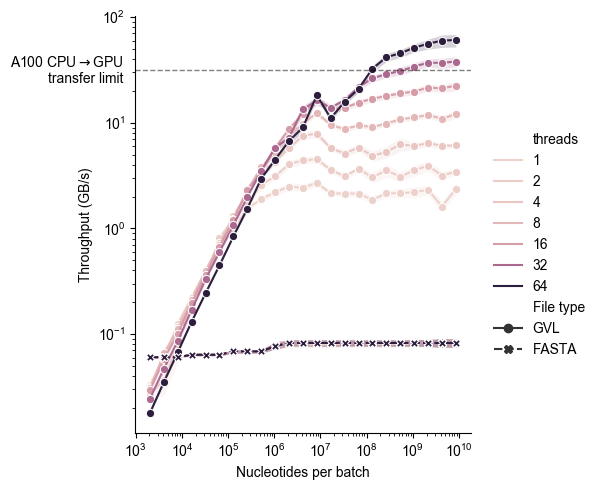

In [94]:
bs_name = r"$\log_{10}$ batch size"

fg = sns.relplot(
    results.unpivot(
        ["throughput", "ref_throughput"],
        index=["seqlen", "threads", "dataset", "batch_size", "n_nucleotides"],
        variable_name="filetype",
        value_name="throughput",
    ).with_columns(
        pl.col("filetype")
        .replace_strict({"throughput": "GVL", "ref_throughput": "FASTA"})
        .alias("File type"),
        pl.col("batch_size").log(10).alias(bs_name),
    ),
    x="n_nucleotides",
    y="throughput",
    hue="threads",
    style="File type",
    kind="line",
    markers=True,
    legend="full",
)
fg.set(
    xlabel="Nucleotides per batch",
    xscale="log",
    ylabel="Throughput (GB/s)",
    yscale="log",
)
ax = fg.axes[0, 0]
ax.axhline(
    31.5,
    c="k",
    ls="--",
    alpha=0.5,
    linewidth=1,
)
ax.text(
    results["n_nucleotides"].min() - 1500,
    31.5,
    r"A100 CPU$\rightarrow$GPU" + "\ntransfer limit",
    va="center",
    ha="right",
)
fg.tight_layout()
fg.savefig(fig_dir / "hap_throughput.svg")
fg.savefig(fig_dir / "hap_throughput.png", dpi=150)

In [90]:
track_results.tail()

dataset,threads,seqlen,batch_size,throughput (MiB/s),n_nucleotides,batch_mb,throughput,bigwig_throughput
str,i64,i64,i64,f64,i64,f64,f64,f64
"""tcga-atac""",2,16384,524288,2865.192178,8589934592,34359.738368,3.004372,0.120223
"""tcga-atac""",2,16384,524288,3690.864941,8589934592,34359.738368,3.870152,0.120223
"""tcga-atac""",2,16384,524288,4581.91256,8589934592,34359.738368,4.804484,0.120223
"""tcga-atac""",2,16384,524288,4617.970088,8589934592,34359.738368,4.842293,0.120223
"""tcga-atac""",2,16384,524288,4572.549024,8589934592,34359.738368,4.794665,0.120223


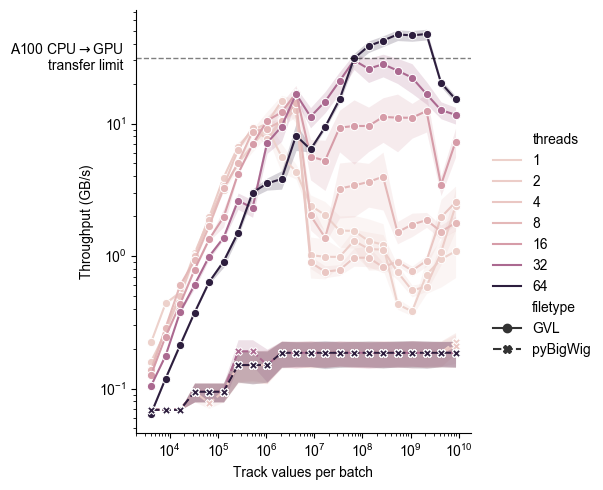

In [93]:
bs_name = r"$\log_{10}$ batch size"

fg = sns.relplot(
    track_results.unpivot(
        ["throughput", "bigwig_throughput"],
        index=["seqlen", "threads", "n_nucleotides"],
        variable_name="filetype",
        value_name="throughput",
    ).with_columns(
        pl.col("filetype").replace_strict(
            {"throughput": "GVL", "bigwig_throughput": "pyBigWig"}
        )
    ),
    x="n_nucleotides",
    y="throughput",
    hue="threads",
    style="filetype",
    kind="line",
    markers=True,
    legend="full",
)
fg.set(
    xlabel="Track values per batch",
    xscale="log",
    ylabel="Throughput (GB/s)",
    yscale="log",
)
ax = fg.axes[0, 0]
ax.axhline(
    31.5,
    c="k",
    ls="--",
    alpha=0.5,
    linewidth=1,
)
ax.text(
    track_results["n_nucleotides"].min() - 3000,
    31.5,
    r"A100 CPU$\rightarrow$GPU" + "\ntransfer limit",
    va="center",
    ha="right",
)
fg.tight_layout()
fg.savefig(fig_dir / "track_throughput.svg")
fg.savefig(fig_dir / "track_throughput.png", dpi=150)